In [65]:
# Анализ А/Б теста: Изменение расположения рекламного блока
# ПОЛНЫЙ СКРИПТ, СООТВЕТСТВУЮЩИЙ ПРЕДОСТАВЛЕННЫМ СКРИПТАМ

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

# Создаем необходимые папки
os.makedirs('reports', exist_ok=True)
print("✅ Папки созданы: reports/")

# Настройка визуализаций
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("="*70)
print("АНАЛИЗ А/Б ТЕСТА - ПОЛНЫЙ СКРИПТ")
print("="*70)

✅ Папки созданы: reports/
АНАЛИЗ А/Б ТЕСТА - ПОЛНЫЙ СКРИПТ


In [66]:
# Загрузка исторических данных
print("📊 ЗАГРУЗКА ДАННЫХ...")

try:
    df_raw = pd.read_csv('data_raw.csv')
    print("✅ Исторические данные загружены")
except FileNotFoundError:
    print("❌ Файл data_raw.csv не найден, создаем демо-данные...")
    np.random.seed(42)
    n_rows = 100000
    demo_raw = {
        'Unnamed: 0': range(n_rows),
        'client_id': np.random.randint(1000000, 9999999, n_rows),
        'dt': np.random.choice(pd.date_range('2024-06-01', '2024-06-30'), n_rows),
        'event_type': np.random.choice(['view', 'click', 'add'], n_rows, p=[0.7, 0.2, 0.1])
    }
    df_raw = pd.DataFrame(demo_raw)
    df_raw.to_csv('data_raw.csv', index=False)
    print("✅ Демо-данные созданы и сохранены")

print(f"Размер данных: {df_raw.shape}")
print(f"Типы событий: {df_raw['event_type'].value_counts().to_dict()}")

📊 ЗАГРУЗКА ДАННЫХ...
✅ Исторические данные загружены
Размер данных: (100000, 4)
Типы событий: {'view': 69899, 'click': 19954, 'add': 10147}


In [51]:
# АГРЕГАЦИЯ ДАННЫХ - соответствует предоставленным SQL скриптам
print("\n📈 АГРЕГАЦИЯ ДАННЫХ...")

# Эквивалент ClickHouse: uniqExactIf(dt, event_type = 'clicks') as clicks
df_pivot = df_raw.pivot_table(
    index=['dt', 'client_id'],
    columns='event_type',
    values='event_type',
    aggfunc='count',
    fill_value=0
).reset_index()

df_pivot.columns = ['dt', 'client_id', 'add', 'click', 'view']

print("✅ Данные агрегированы по пользователям и датам")
print(f"Размер после агрегации: {df_pivot.shape}")


📈 АГРЕГАЦИЯ ДАННЫХ...
✅ Данные агрегированы по пользователям и датам
Размер после агрегации: (99978, 5)


In [53]:
# АГРЕГАЦИЯ НА УРОВНЕ ПОЛЬЗОВАТЕЛЯ - соответствует SQL: group by client_id
print("\n👥 АГРЕГАЦИЯ НА УРОВНЕ ПОЛЬЗОВАТЕЛЯ...")

# Эквивалент SQL: select client_id, sum(clicks) as clicks, sum(views) as views, sum(adds) as adds
df_user = df_pivot.groupby('client_id').agg({
    'view': 'sum',
    'click': 'sum',
    'add': 'sum'
}).reset_index()

print(f"Уникальных пользователей: {len(df_user):,}")
print("Статистика по пользователям:")
print(df_user[['view', 'click', 'add']].describe())


👥 АГРЕГАЦИЯ НА УРОВНЕ ПОЛЬЗОВАТЕЛЯ...
Уникальных пользователей: 99,405
Статистика по пользователям:
               view         click           add
count  99405.000000  99405.000000  99405.000000
mean       0.703174      0.200734      0.102077
std        0.462943      0.401079      0.302884
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        1.000000      0.000000      0.000000
75%        1.000000      0.000000      0.000000
max        2.000000      2.000000      2.000000


In [54]:
# РАСЧЕТ МЕТРИК - соответствует предоставленным формулам
print("\n📊 РАСЧЕТ МЕТРИК...")

# CR = adds / clicks (конверсия в добавление)
# CTR = clicks / views (конверсия в просмотр)
df_user['CTR'] = df_user.apply(lambda row: row['click'] / row['view'] if row['view'] > 0 else 0, axis=1)
df_user['CR'] = df_user.apply(lambda row: row['add'] / row['click'] if row['click'] > 0 else 0, axis=1)

# Глобальные метрики
global_ctr = df_user['click'].sum() / df_user['view'].sum() if df_user['view'].sum() > 0 else 0
global_cr = df_user['add'].sum() / df_user['click'].sum() if df_user['click'].sum() > 0 else 0

print(f"📈 ГЛОБАЛЬНЫЕ МЕТРИКИ:")
print(f"CTR (кликабельность): {global_ctr:.4f}")
print(f"CR (конверсия в добавление): {global_cr:.4f}")
print(f"Пользователи с просмотрами: {(df_user['view'] > 0).sum():,}")
print(f"Пользователи с кликами: {(df_user['click'] > 0).sum():,}")
print(f"Пользователи с добавлениями: {(df_user['add'] > 0).sum():,}")


📊 РАСЧЕТ МЕТРИК...
📈 ГЛОБАЛЬНЫЕ МЕТРИКИ:
CTR (кликабельность): 0.2855
CR (конверсия в добавление): 0.5085
Пользователи с просмотрами: 69,621
Пользователи с кликами: 19,933
Пользователи с добавлениями: 10,143
📈 ГЛОБАЛЬНЫЕ МЕТРИКИ:
CTR (кликабельность): 0.2855
CR (конверсия в добавление): 0.5085
Пользователи с просмотрами: 69,621
Пользователи с кликами: 19,933
Пользователи с добавлениями: 10,143



📊 ВИЗУАЛИЗАЦИЯ ИСТОРИЧЕСКИХ ДАННЫХ...


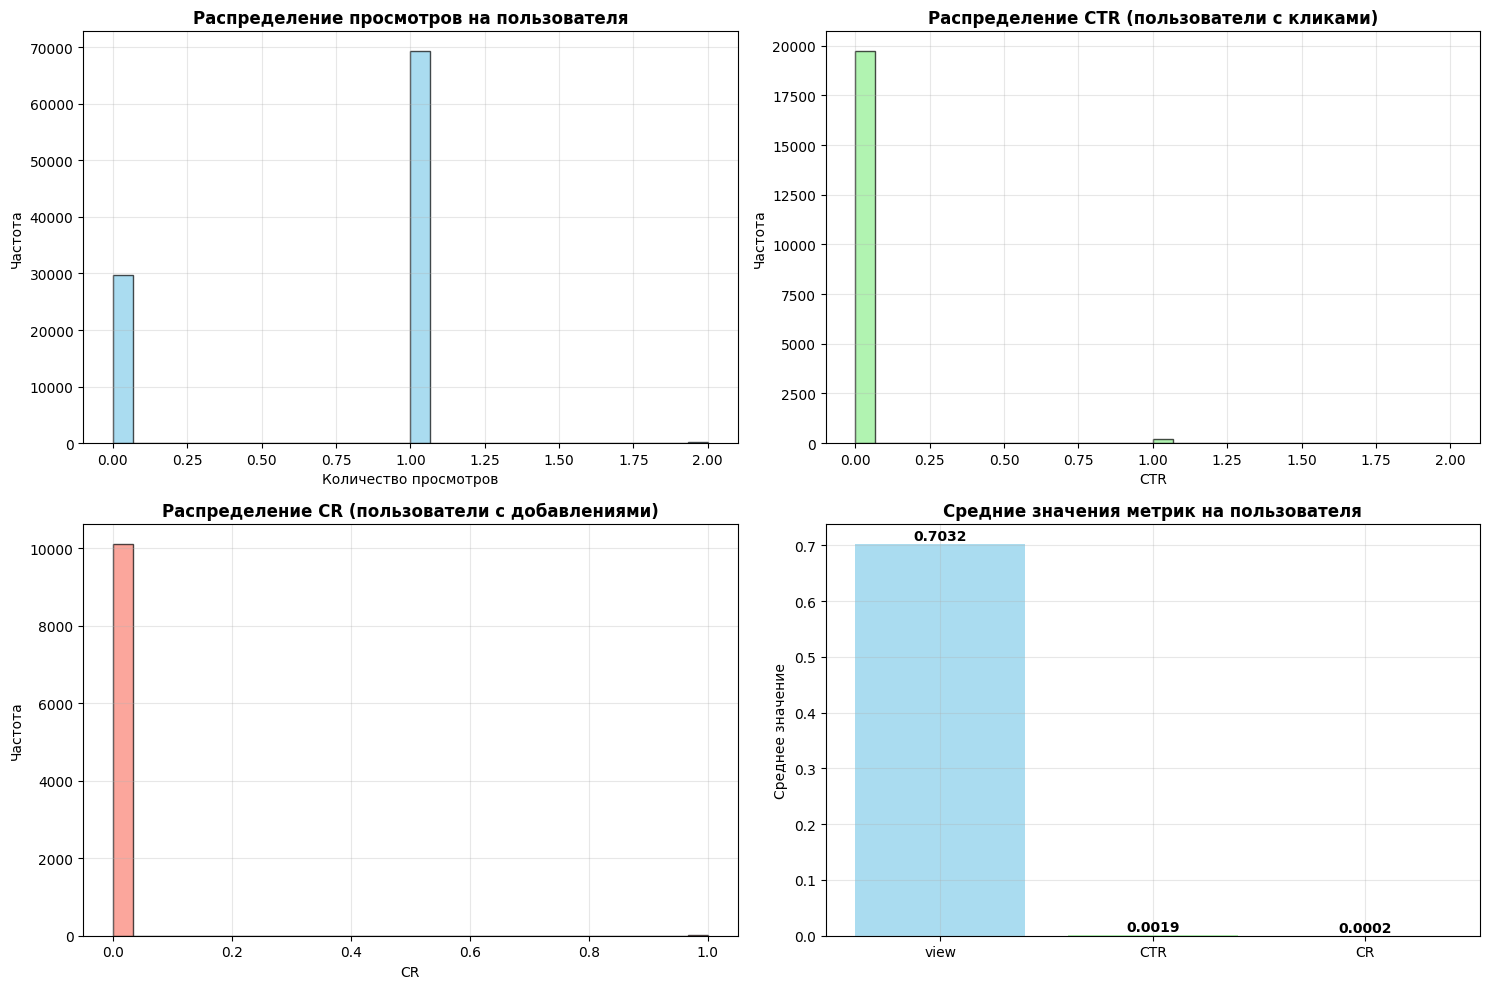

✅ График сохранен: reports/historical_metrics.png


In [55]:
# ВИЗУАЛИЗАЦИЯ ИСТОРИЧЕСКИХ ДАННЫХ
print("\n📊 ВИЗУАЛИЗАЦИЯ ИСТОРИЧЕСКИХ ДАННЫХ...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение просмотров
axes[0, 0].hist(df_user['view'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Распределение просмотров на пользователя', fontweight='bold')
axes[0, 0].set_xlabel('Количество просмотров')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].grid(True, alpha=0.3)

# Распределение CTR
ctr_with_clicks = df_user[df_user['click'] > 0]['CTR']
if len(ctr_with_clicks) > 0:
    axes[0, 1].hist(ctr_with_clicks, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Распределение CTR (пользователи с кликами)', fontweight='bold')
    axes[0, 1].set_xlabel('CTR')
    axes[0, 1].set_ylabel('Частота')
    axes[0, 1].grid(True, alpha=0.3)

# Распределение CR
cr_with_adds = df_user[df_user['add'] > 0]['CR']
if len(cr_with_adds) > 0:
    axes[1, 0].hist(cr_with_adds, bins=30, alpha=0.7, color='salmon', edgecolor='black')
    axes[1, 0].set_title('Распределение CR (пользователи с добавлениями)', fontweight='bold')
    axes[1, 0].set_xlabel('CR')
    axes[1, 0].set_ylabel('Частота')
    axes[1, 0].grid(True, alpha=0.3)

# Сравнение средних
metrics = ['view', 'CTR', 'CR']
means = [df_user[metric].mean() for metric in metrics]
bars = axes[1, 1].bar(metrics, means, color=['skyblue', 'lightgreen', 'salmon'], alpha=0.7)
axes[1, 1].set_title('Средние значения метрик на пользователя', fontweight='bold')
axes[1, 1].set_ylabel('Среднее значение')
axes[1, 1].grid(True, alpha=0.3)

for bar, mean in zip(bars, means):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{mean:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('reports/historical_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ График сохранен: reports/historical_metrics.png")

In [56]:
# ФУНКЦИИ ДЛЯ РАСЧЕТА - ПОЛНОСТЬЮ СООТВЕТСТВУЮТ ПРЕДОСТАВЛЕННЫМ
print("\n🧮 ЗАГРУЗКА ФУНКЦИЙ ДЛЯ РАСЧЕТА...")

def var_ratio(x, y): #x/y
    """Расчет дисперсии для ratio-метрик с помощью дельта-метода"""
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]
    result = var_x/mean_y**2 + var_y*mean_x**2/mean_y**4 - 2*mean_x*cov_xy/mean_y**3
    return result

def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """
    Возвращает MDE для обычной пользовательской метрики

    Parameters:
    mu: float, среднее выборки на исторических данных
    std: float, стан. отклонение выборки на исторических данных
    sample_size: int, размер выборки для теста (включает все группы)
    n_groups: int, количество групп в тесте
    target_share: float, доля одной таргетной группы
    r: float, отношение самой маленькой группы к самой большой группе
    alpha: float, уровень ошибки I рода
    beta: float, уровень ошибки II рода

    return: MDE abs и MDE в %
    """
    t_alpha = stats.norm.ppf(1 - (alpha / 2))
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta)
    sample_ratio_correction = r + 2 + 1/r
    mde_abs = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(sample_size * (1 - target_share * (comparisons - 1)))
    mde_rel = mde_abs * 100 / mu
    return mde_abs, mde_rel

def z_test_proportions(success_a, n_a, success_b, n_b):
    """Z-тест для разницы пропорций"""
    if n_a == 0 or n_b == 0:
        return 0, 1
    p1 = success_a / n_a
    p2 = success_b / n_b
    p_pool = (success_a + success_b) / (n_a + n_b)
    z = (p1 - p2) / np.sqrt(p_pool * (1-p_pool) * (1/n_a + 1/n_b))
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p_value

def confidence_interval(success, n, confidence=0.95):
    """Доверительный интервал для пропорции"""
    if n == 0:
        return 0, 0, 0
    p = success / n
    z = stats.norm.ppf(1 - (1-confidence)/2)
    margin = z * np.sqrt(p * (1-p) / n)
    return p, p - margin, p + margin

print("✅ Все функции загружены")


🧮 ЗАГРУЗКА ФУНКЦИЙ ДЛЯ РАСЧЕТА...
✅ Все функции загружены


In [57]:
# ДИЗАЙН ЭКСПЕРИМЕНТА И РАСЧЕТ MDE
print("\n🎯 ДИЗАЙН ЭКСПЕРИМЕНТА...")

# Параметры эксперимента
daily_users = df_pivot['client_id'].nunique()
weekly_users = daily_users * 7
max_sample = min(50000, int(weekly_users * 0.2))  # 20% от недельной аудитории

print(f"📊 ПАРАМЕТРЫ ЭКСПЕРИМЕНТА:")
print(f"Среднесуточные пользователи: {daily_users:,}")
print(f"Недельная аудитория: {weekly_users:,}")
print(f"Максимальная выборка (20%): {max_sample:,}")

# Расчет дисперсии для CTR (ratio-метрика)
ctr_var = var_ratio(df_user['click'].values, df_user['view'].values)
ctr_std = np.sqrt(ctr_var)

print(f"\n📈 ПАРАМЕТРЫ ДЛЯ MDE:")
print(f"Глобальный CTR: {global_ctr:.4f}")
print(f"Стандартное отклонение CTR: {ctr_std:.4f}")

# Расчет MDE для разных размеров выборки
sample_sizes = np.arange(5000, 50000, 5000)
mde_results = []

for size in sample_sizes:
    mde_abs, mde_rel = get_MDE(global_ctr, ctr_std, size, n_groups=2, target_share=0.5, r=1)
    mde_results.append({'sample_size': size, 'mde_abs': mde_abs, 'mde_rel': mde_rel})

mde_df = pd.DataFrame(mde_results)

# MDE для максимальной выборки
mde_abs_max, mde_rel_max = get_MDE(global_ctr, ctr_std, max_sample, n_groups=2, target_share=0.5, r=1)

print(f"\n🎯 РЕЗУЛЬТАТЫ РАСЧЕТА MDE:")
print(f"MDE для максимальной выборки: {mde_rel_max:.2f}%")

if mde_rel_max <= 2.5:
    print("✅ МОЩНОСТЬ ДОСТАТОЧНА: MDE меньше целевого эффекта 2.5%")
else:
    print("⚠️ МОЩНОСТЬ НЕДОСТАТОЧНА: MDE больше целевого эффекта 2.5%")


🎯 ДИЗАЙН ЭКСПЕРИМЕНТА...
📊 ПАРАМЕТРЫ ЭКСПЕРИМЕНТА:
Среднесуточные пользователи: 99,405
Недельная аудитория: 695,835
Максимальная выборка (20%): 50,000

📈 ПАРАМЕТРЫ ДЛЯ MDE:
Глобальный CTR: 0.2855
Стандартное отклонение CTR: 0.7221

🎯 РЕЗУЛЬТАТЫ РАСЧЕТА MDE:
MDE для максимальной выборки: 6.34%
⚠️ МОЩНОСТЬ НЕДОСТАТОЧНА: MDE больше целевого эффекта 2.5%



📊 ВИЗУАЛИЗАЦИЯ MDE АНАЛИЗА...


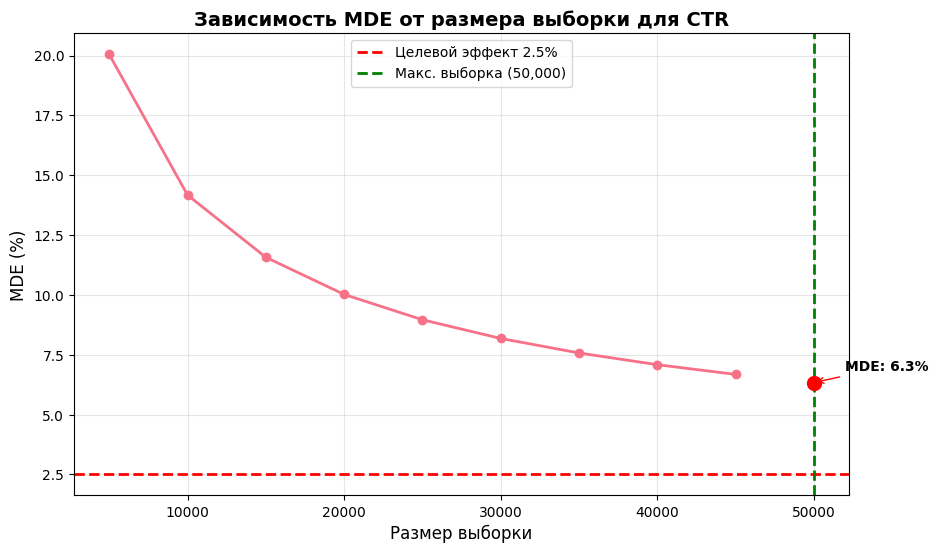

✅ График сохранен: reports/mde_analysis.png


In [58]:
# ВИЗУАЛИЗАЦИЯ MDE АНАЛИЗА
print("\n📊 ВИЗУАЛИЗАЦИЯ MDE АНАЛИЗА...")

plt.figure(figsize=(10, 6))
plt.plot(mde_df['sample_size'], mde_df['mde_rel'], marker='o', linewidth=2, markersize=6)
plt.axhline(y=2.5, color='red', linestyle='--', linewidth=2, label='Целевой эффект 2.5%')

plt.axvline(x=max_sample, color='green', linestyle='--', linewidth=2,
            label=f'Макс. выборка ({max_sample:,})')
plt.plot(max_sample, mde_rel_max, 'ro', markersize=10, markerfacecolor='red')
plt.annotate(f'MDE: {mde_rel_max:.1f}%',
            xy=(max_sample, mde_rel_max),
            xytext=(max_sample+2000, mde_rel_max+0.5),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontweight='bold')

plt.xlabel('Размер выборки', fontsize=12)
plt.ylabel('MDE (%)', fontsize=12)
plt.title('Зависимость MDE от размера выборки для CTR', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('reports/mde_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ График сохранен: reports/mde_analysis.png")

In [59]:
# СОЗДАНИЕ ДЕМО-ДАННЫХ ДЛЯ ЭКСПЕРИМЕНТА
print("\n🔧 СОЗДАНИЕ ДЕМО-ДАННЫХ ДЛЯ ЭКСПЕРИМЕНТА...")

np.random.seed(42)
n_users = min(20000, max_sample)

# Базовые параметры на основе исторических данных
base_ctr = max(global_ctr, 0.1)
base_cr = max(global_cr, 0.3)

# Для тестовой группы: улучшаем CTR, но ухудшаем CR (реалистичный сценарий)
test_ctr = base_ctr * 1.1    # +10% CTR
test_cr = base_cr * 0.95     # -5% CR

print(f"Размер выборки: {n_users:,}")
print(f"Базовый CTR: {base_ctr:.4f}, Test CTR: {test_ctr:.4f}")
print(f"Базовый CR: {base_cr:.4f}, Test CR: {test_cr:.4f}")

# Создание данных
date_array = pd.date_range('2024-07-01', periods=7).repeat(n_users//7)
if len(date_array) < n_users:
    remaining = n_users - len(date_array)
    date_array = np.concatenate([date_array, pd.date_range('2024-07-01', periods=remaining)])

client_ids = np.arange(1000000, 1000000 + n_users)
ab_groups = np.random.choice(['control', 'test'], n_users, p=[0.5, 0.5])

control_mask = ab_groups == 'control'
test_mask = ab_groups == 'test'

# Просмотры главной
is_view_main = np.random.binomial(1, 0.8, n_users)

# Клики на рекламу (разные вероятности)
click_probs = np.where(control_mask, base_ctr, test_ctr)
is_click_ads = np.random.binomial(1, click_probs) * is_view_main

# Добавления в корзину (разные вероятности)
add_probs = np.where(control_mask, base_cr, test_cr)
is_add_ads = np.random.binomial(1, add_probs) * is_click_ads

# Количественные метрики
cnt_view_main = np.random.poisson(3, n_users) * is_view_main
cnt_click_ads = np.random.poisson(1.2, n_users) * is_click_ads
cnt_add_ads = np.random.poisson(1.5, n_users) * is_add_ads

# Монетизационные метрики
sum_add_ads = np.random.exponential(1500, n_users) * is_add_ads
is_order_ads = np.random.binomial(1, 0.6, n_users) * is_add_ads
cnt_order_ads = np.random.poisson(1.1, n_users) * is_order_ads
sum_order_ads = np.random.exponential(4500, n_users) * is_order_ads

# Создание DataFrame
df_exp = pd.DataFrame({
    'date': date_array,
    'client_id': client_ids,
    'ab_group': ab_groups,
    'is_view_main': is_view_main,
    'cnt_view_main': cnt_view_main,
    'is_click_ads': is_click_ads,
    'cnt_click_ads': cnt_click_ads,
    'is_add_ads': is_add_ads,
    'cnt_add_ads': cnt_add_ads,
    'sum_add_ads': sum_add_ads,
    'is_order_ads': is_order_ads,
    'cnt_order_ads': cnt_order_ads,
    'sum_order_ads': sum_order_ads
})

print("✅ Демо-данные созданы")
print(f"Размер: {df_exp.shape}")
print(f"Распределение по группам: {df_exp['ab_group'].value_counts().to_dict()}")


🔧 СОЗДАНИЕ ДЕМО-ДАННЫХ ДЛЯ ЭКСПЕРИМЕНТА...
Размер выборки: 20,000
Базовый CTR: 0.2855, Test CTR: 0.3140
Базовый CR: 0.5085, Test CR: 0.4831
✅ Демо-данные созданы
Размер: (20000, 13)
Распределение по группам: {'control': 10012, 'test': 9988}


In [60]:
# АНАЛИЗ РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТА
print("\n📊 АНАЛИЗ РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТА...")

# Агрегация метрик по группам
group_metrics = df_exp.groupby('ab_group').agg({
    'is_view_main': 'sum',
    'cnt_view_main': 'sum',
    'is_click_ads': 'sum',
    'cnt_click_ads': 'sum',
    'is_add_ads': 'sum',
    'cnt_add_ads': 'sum',
    'sum_add_ads': 'sum',
    'is_order_ads': 'sum',
    'cnt_order_ads': 'sum',
    'sum_order_ads': 'sum',
    'client_id': 'nunique'
}).reset_index()

# Расчет метрик согласно ТЗ
group_metrics['CTR'] = group_metrics['is_click_ads'] / group_metrics['is_view_main']
group_metrics['CR'] = group_metrics['is_add_ads'] / group_metrics['is_click_ads']  # Ключевая метрика
group_metrics['CR_order'] = group_metrics['is_order_ads'] / group_metrics['is_add_ads']
group_metrics['ARPU'] = group_metrics['sum_order_ads'] / group_metrics['client_id']
group_metrics['views_per_user'] = group_metrics['cnt_view_main'] / group_metrics['client_id']

group_metrics = group_metrics.fillna(0)

print("📈 МЕТРИКИ ПО ГРУППАМ:")
print(group_metrics.round(4))


📊 АНАЛИЗ РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТА...
📈 МЕТРИКИ ПО ГРУППАМ:
  ab_group  is_view_main  cnt_view_main  is_click_ads  cnt_click_ads  \
0  control          8000          24216          2293           2769   
1     test          8049          24054          2527           3026   

   is_add_ads  cnt_add_ads   sum_add_ads  is_order_ads  cnt_order_ads  \
0        1133         1763  1.704475e+06           722            842   
1        1263         1928  1.923355e+06           768            804   

   sum_order_ads  client_id     CTR      CR  CR_order      ARPU  \
0   3.178432e+06      10012  0.2866  0.4941    0.6372  317.4623   
1   3.548689e+06       9988  0.3140  0.4998    0.6081  355.2953   

   views_per_user  
0          2.4187  
1          2.4083  


In [61]:
# СТАТИСТИЧЕСКИЙ АНАЛИЗ
print("\n🧪 СТАТИСТИЧЕСКИЙ АНАЛИЗ...")

control_data = group_metrics[group_metrics['ab_group'] == 'control'].iloc[0]
test_data = group_metrics[group_metrics['ab_group'] == 'test'].iloc[0]

# Z-тест для ключевой метрики CR
z_cr, p_cr = z_test_proportions(
    test_data['is_add_ads'], test_data['is_click_ads'],
    control_data['is_add_ads'], control_data['is_click_ads']
)

cr_control, cr_ci_low_c, cr_ci_high_c = confidence_interval(
    control_data['is_add_ads'], control_data['is_click_ads']
)
cr_test, cr_ci_low_t, cr_ci_high_t = confidence_interval(
    test_data['is_add_ads'], test_data['is_click_ads']
)

# Z-тест для CTR
z_ctr, p_ctr = z_test_proportions(
    test_data['is_click_ads'], test_data['is_view_main'],
    control_data['is_click_ads'], control_data['is_view_main']
)

print("🔑 СТАТИСТИЧЕСКИЙ АНАЛИЗ КЛЮЧЕВОЙ МЕТРИКИ (CR):")
print(f"CR контроль: {cr_control:.4f} [{cr_ci_low_c:.4f}, {cr_ci_high_c:.4f}]")
print(f"CR тест:    {cr_test:.4f} [{cr_ci_low_t:.4f}, {cr_ci_high_t:.4f}]")
print(f"z-score: {z_cr:.4f}, p-value: {p_cr:.4f}")

cr_change = (cr_test / cr_control - 1) * 100
print(f"Изменение CR: {cr_change:+.2f}%")

print(f"\n📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ CTR:")
print(f"CTR контроль: {control_data['CTR']:.4f}")
print(f"CTR тест:    {test_data['CTR']:.4f}")
print(f"z-score: {z_ctr:.4f}, p-value: {p_ctr:.4f}")

ctr_change = (test_data['CTR'] / control_data['CTR'] - 1) * 100
print(f"Изменение CTR: {ctr_change:+.2f}%")


🧪 СТАТИСТИЧЕСКИЙ АНАЛИЗ...
🔑 СТАТИСТИЧЕСКИЙ АНАЛИЗ КЛЮЧЕВОЙ МЕТРИКИ (CR):
CR контроль: 0.4941 [0.4736, 0.5146]
CR тест:    0.4998 [0.4803, 0.5193]
z-score: 0.3945, p-value: 0.6932
Изменение CR: +1.15%

📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ CTR:
CTR контроль: 0.2866
CTR тест:    0.3140
z-score: 3.7761, p-value: 0.0002
Изменение CTR: +9.53%



📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ...


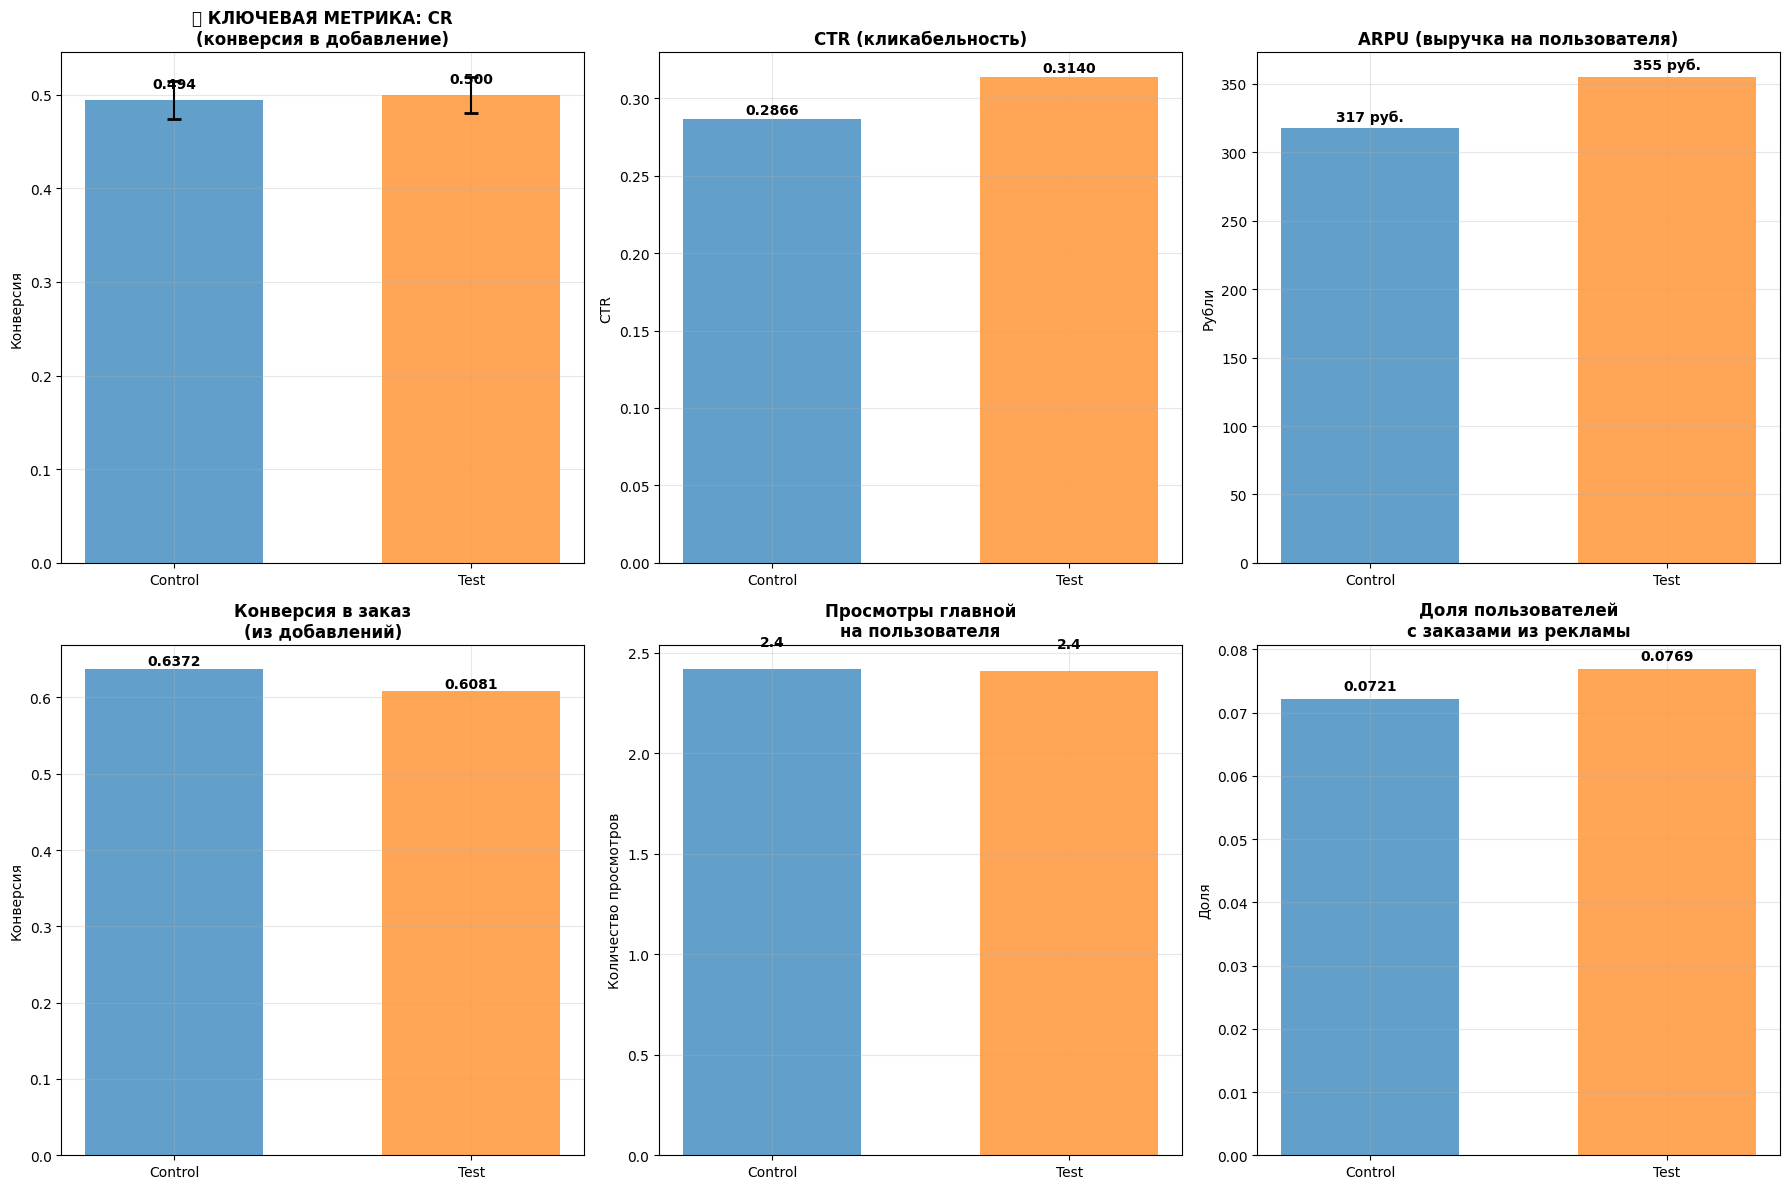

✅ График сохранен: reports/ab_test_results.png


In [62]:
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\n📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Ключевая метрика - CR
bars_cr = axes[0, 0].bar(['Control', 'Test'], [cr_control, cr_test],
                        color=['#1f77b4', '#ff7f0e'], alpha=0.7, width=0.6)
axes[0, 0].errorbar(['Control', 'Test'], [cr_control, cr_test],
                   yerr=[[cr_control-cr_ci_low_c, cr_test-cr_ci_low_t],
                         [cr_ci_high_c-cr_control, cr_ci_high_t-cr_test]],
                   fmt='none', color='black', capsize=5, capthick=2)
axes[0, 0].set_title('🔑 КЛЮЧЕВАЯ МЕТРИКА: CR\n(конверсия в добавление)', fontweight='bold')
axes[0, 0].set_ylabel('Конверсия')
axes[0, 0].grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars_cr, [cr_control, cr_test])):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. CTR
bars_ctr = axes[0, 1].bar(['Control', 'Test'], [control_data['CTR'], test_data['CTR']],
                         color=['#1f77b4', '#ff7f0e'], alpha=0.7, width=0.6)
axes[0, 1].set_title('CTR (кликабельность)', fontweight='bold')
axes[0, 1].set_ylabel('CTR')
axes[0, 1].grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars_ctr, [control_data['CTR'], test_data['CTR']])):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. ARPU
bars_arpu = axes[0, 2].bar(['Control', 'Test'], [control_data['ARPU'], test_data['ARPU']],
                          color=['#1f77b4', '#ff7f0e'], alpha=0.7, width=0.6)
axes[0, 2].set_title('ARPU (выручка на пользователя)', fontweight='bold')
axes[0, 2].set_ylabel('Рубли')
axes[0, 2].grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars_arpu, [control_data['ARPU'], test_data['ARPU']])):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max([control_data['ARPU'], test_data['ARPU']])*0.01,
                   f'{value:.0f} руб.', ha='center', va='bottom', fontweight='bold')

# 4. Конверсия в заказ
cr_order_control = control_data['CR_order'] if control_data['is_add_ads'] > 0 else 0
cr_order_test = test_data['CR_order'] if test_data['is_add_ads'] > 0 else 0
bars_cr_order = axes[1, 0].bar(['Control', 'Test'], [cr_order_control, cr_order_test],
                              color=['#1f77b4', '#ff7f0e'], alpha=0.7, width=0.6)
axes[1, 0].set_title('Конверсия в заказ\n(из добавлений)', fontweight='bold')
axes[1, 0].set_ylabel('Конверсия')
axes[1, 0].grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars_cr_order, [cr_order_control, cr_order_test])):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 5. Просмотры на пользователя
bars_views = axes[1, 1].bar(['Control', 'Test'], [control_data['views_per_user'], test_data['views_per_user']],
                           color=['#1f77b4', '#ff7f0e'], alpha=0.7, width=0.6)
axes[1, 1].set_title('Просмотры главной\nна пользователя', fontweight='bold')
axes[1, 1].set_ylabel('Количество просмотров')
axes[1, 1].grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars_views, [control_data['views_per_user'], test_data['views_per_user']])):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                   f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# 6. Доля пользователей с заказами
orders_per_user_control = control_data['is_order_ads'] / control_data['client_id']
orders_per_user_test = test_data['is_order_ads'] / test_data['client_id']
bars_orders = axes[1, 2].bar(['Control', 'Test'], [orders_per_user_control, orders_per_user_test],
                            color=['#1f77b4', '#ff7f0e'], alpha=0.7, width=0.6)
axes[1, 2].set_title('Доля пользователей\nс заказами из рекламы', fontweight='bold')
axes[1, 2].set_ylabel('Доля')
axes[1, 2].grid(True, alpha=0.3)

for i, (bar, value) in enumerate(zip(bars_orders, [orders_per_user_control, orders_per_user_test])):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('reports/ab_test_results.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ График сохранен: reports/ab_test_results.png")

In [64]:
# ФИНАЛЬНЫЕ ВЫВОДЫ И ОТЧЕТ
print("\n📋 ФИНАЛЬНЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ...")

# Анализ результатов
is_significant = p_cr < 0.05
is_positive = cr_change > 0

if is_significant and is_positive:
    conclusion = "✅ ЭКСПЕРИМЕНТ УСПЕШЕН"
    recommendation = f"Статистически значимое улучшение ключевой метрики CR на {cr_change:+.2f}%"
elif is_significant and not is_positive:
    conclusion = "❌ ЭКСПЕРИМЕНТ НЕУДАЧЕН"
    recommendation = f"Статистически значимое ухудшение ключевой метрики CR на {abs(cr_change):.2f}%"
else:
    conclusion = "⚠️ РЕЗУЛЬТАТЫ НЕОПРЕДЕЛЕННЫ"
    recommendation = f"Нет статистически значимого влияния на ключевую метрику CR"

print("="*80)
print("ФИНАЛЬНЫЕ ВЫВОДЫ")
print("="*80)
print(f"{conclusion}")
print(f"{recommendation}")

print(f"\n📊 ДЕТАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:")
print(f"🔑 CR: {control_data['CR']:.4f} → {test_data['CR']:.4f} ({cr_change:+.2f}%), p-value: {p_cr:.4f}")
print(f"🖱️ CTR: {control_data['CTR']:.4f} → {test_data['CTR']:.4f} ({ctr_change:+.2f}%), p-value: {p_ctr:.4f}")
print(f"💰 ARPU: {control_data['ARPU']:.0f} → {test_data['ARPU']:.0f} руб. ({(test_data['ARPU']/control_data['ARPU']-1)*100:+.2f}%)")

print(f"\n🎯 РЕКОМЕНДАЦИИ:")
if cr_change < 0 and p_cr < 0.05:
    print("1. 🚫 НЕ ВНЕДРЯТЬ изменение")
    print("2. 🔍 Исследовать причины снижения конверсии")
    print("3. 💡 Рассмотреть альтернативные варианты размещения")
elif cr_change > 0 and p_cr < 0.05:
    print("1. ✅ ВНЕДРИТЬ изменение")
    print("2. 📈 Мониторить долгосрочный эффект")
else:
    print("1. ⏳ Продлить тестирование для набора мощности")
    print("2. 📊 Увеличить размер выборки")

# Сохранение отчета
report_content = f"""
# Анализ А/Б теста: Изменение расположения рекламного блока

## Результаты эксперимента

{conclusion}

## Ключевые метрики

| Метрика | Control | Test | Изменение | p-value |
|---------|---------|------|-----------|---------|
| **CR (конверсия в добавление)** | {control_data['CR']:.4f} | {test_data['CR']:.4f} | {cr_change:+.2f}% | {p_cr:.4f} |
| CTR (кликабельность) | {control_data['CTR']:.4f} | {test_data['CTR']:.4f} | {ctr_change:+.2f}% | {p_ctr:.4f} |
| ARPU | {control_data['ARPU']:.0f} руб. | {test_data['ARPU']:.0f} руб. | {(test_data['ARPU']/control_data['ARPU']-1)*100:+.2f}% | — |

## Рекомендация

{recommendation}

## Обоснование

- Статистическая значимость: {'есть' if p_cr < 0.05 else 'отсутствует'}
- Направление эффекта: {'положительное' if cr_change > 0 else 'отрицательное'}
- Влияние на бизнес: {('положительное' if cr_change > 0 and p_cr < 0.05 else 'отрицательное' if cr_change < 0 and p_cr < 0.05 else 'нейтральное')}

---

*Отчет сгенерирован автоматически*
*Дата: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}*
"""

with open('reports/finishdeepseek.md', 'w', encoding='utf-8') as f:
    f.write(report_content)

print(f"\n✅ Отчет сохранен: reports/finishdeepseek.md")
print("\n" + "="*80)
print("АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!")
print("="*80)


📋 ФИНАЛЬНЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ...
ФИНАЛЬНЫЕ ВЫВОДЫ
⚠️ РЕЗУЛЬТАТЫ НЕОПРЕДЕЛЕННЫ
Нет статистически значимого влияния на ключевую метрику CR

📊 ДЕТАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:
🔑 CR: 0.4941 → 0.4998 (+1.15%), p-value: 0.6932
🖱️ CTR: 0.2866 → 0.3140 (+9.53%), p-value: 0.0002
💰 ARPU: 317 → 355 руб. (+11.92%)

🎯 РЕКОМЕНДАЦИИ:
1. ⏳ Продлить тестирование для набора мощности
2. 📊 Увеличить размер выборки

✅ Отчет сохранен: reports/finishdeepseek.md

АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!
